Batch Dates

In [ ]:

import pandas as pd

dataset1 = "Solar_flare_RHESSI_2004_05.csv"
df = pd.read_csv(dataset1)

start_date_set1 = pd.to_datetime('2004-01-01')
end_date_set1 = start_date_set1 + pd.DateOffset(months=24)

batch_size = pd.DateOffset(months=4)
overlap = pd.DateOffset(months=2)

batch_dates = []

current_start = start_date_set1
while current_start < end_date_set1:
    current_end = current_start + batch_size
    batch_dates.append((current_start, current_end))
    current_start = current_start + batch_size - overlap


for i, (batch_start, batch_end) in enumerate(batch_dates):
    print(f"Batch {i + 1}: {batch_start} - {batch_end}")

Ploting Query Points

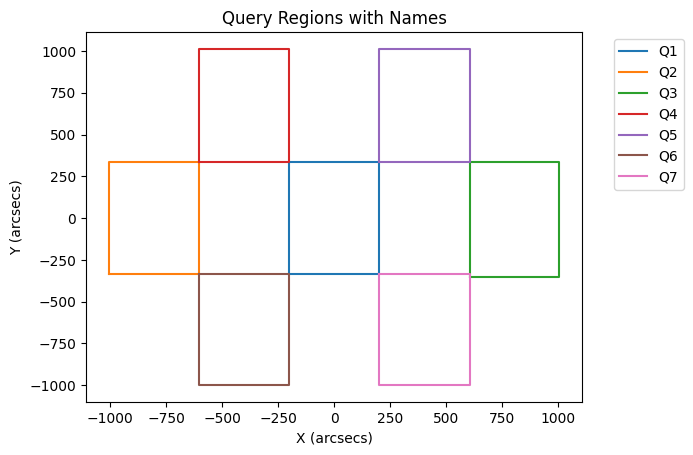

In [9]:
import matplotlib.pyplot as plt

query_points = {
    'Q1': {'coordinates': (0, 0), 'range': ([-201, 201], [-335, 335])},
    'Q2': {'coordinates': (-805, 0), 'range': ([-1007, -605], [-335, 335])},
    'Q3': {'coordinates': (805, 0), 'range': ([605, 1005], [-355, 335])},
    'Q4': {'coordinates': (-403, 674), 'range': ([-605, -201], [335, 1012])},
    'Q5': {'coordinates': (403, 674), 'range': ([201, 605], [335, 1012])},
    'Q6': {'coordinates': (-403, -667), 'range': ([-605, -201], [-335, -998])},
    'Q7': {'coordinates': (403, -667), 'range': ([201, 605], [-335, -998])},
}

fig, ax = plt.subplots()

for query, info in query_points.items():
    x_range = info['range'][0]
    y_range = info['range'][1]
    
    ax.plot([x_range[0], x_range[0], x_range[1], x_range[1], x_range[0]], 
            [y_range[0], y_range[1], y_range[1], y_range[0], y_range[0]], label=query)

ax.set_xlabel('X (arcsecs)')
ax.set_ylabel('Y (arcsecs)')
ax.set_title('Query Regions with Names')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

Method 1 Map 1 First 4 Months

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV



dataset1 = "Solar_flare_RHESSI_2004_05.csv"

df = pd.read_csv(dataset1)

df['dt.start'] = pd.to_datetime(df['dt.start'])
start_date = pd.to_datetime('2004-01-01')
end_date = start_date + pd.DateOffset(months = 4)
df = df[(df['dt.start'] >= start_date) & (df['dt.start'] <= end_date)]
df = df[['total.counts', 'x.pos.asec', 'y.pos.asec']]

flare_events = df

# query points
query_points = {
    'Q1': {'coordinates': (0, 0), 'range': ([-201, 201], [-335, 335])},
    'Q2': {'coordinates': (-805, 0), 'range': ([-1007, -605], [-335, 335])},
    'Q3': {'coordinates': (805, 0), 'range': ([605, 1005], [-355, 335])},
    'Q4': {'coordinates': (-403, 674), 'range': ([-605, -201], [335, 1012])},
    'Q5': {'coordinates': (403, 674), 'range': ([201, 605], [335, 1012])},
    'Q6': {'coordinates': (-403, -667), 'range': ([-605, -201], [-335, -998])},
    'Q7': {'coordinates': (403, -667), 'range': ([201, 605], [-335, -998])},
}


# Gaussian kernel function
def gaussian_kernel(x, y, X, Y, sigma):
    return np.exp(-((x - X)**2 + (y - Y)**2) / (2 * sigma**2))

# Estimate intensity at each query point
def estimate_intensity(query_points, flare_events, sigma):
    estimated_intensities = []
    for query_name, query_info in query_points.items():
        X_q, Y_q = query_info['coordinates']
        intensity = 0
        for _, row in flare_events.iterrows():
            X_i, Y_i, total_counts = row['x.pos.asec'], row['y.pos.asec'], row['total.counts']
            intensity += total_counts * gaussian_kernel(X_q, Y_q, X_i, Y_i, sigma)
        estimated_intensities.append((query_name, intensity))
    return estimated_intensities


sigma = 250.0

# Estimate intensity at query points
intensities = estimate_intensity(query_points, flare_events, sigma)

# Print the estimated intensities
for query_name, intensity in intensities:
    print(f"{query_name}: Intensity = {intensity:.2f}")

# Create a grid for the density map
x_min, x_max = -1200, 1200 
y_min, y_max = -1200, 1200  
step = 10  

xx, yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

grid_points = np.vstack([xx.ravel(), yy.ravel()]).T

# Create a KDE model
kde = KernelDensity(bandwidth=sigma, kernel='gaussian')
kde.fit(flare_events[['x.pos.asec', 'y.pos.asec']]) 

# Calculate the log-densities at each point on the grid
log_densities = kde.score_samples(grid_points)

density_map = np.exp(log_densities).reshape(xx.shape)

# Create the density map
plt.imshow(density_map, extent=(x_min, x_max, y_min, y_max), origin='lower', cmap='inferno')
plt.colorbar(label='Intensity')
plt.scatter([p['coordinates'][0] for p in query_points.values()], [p['coordinates'][1] for p in query_points.values()], color='red', marker='x', label='Query Points')

# labels and legend
plt.xlabel('X (arcseconds)')
plt.ylabel('Y (arcseconds)')
plt.title('Intensity Map for First 4 Months')
plt.legend()

plt.show()

Method 1 Map 2 Last 4 Months

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV



dataset1 = "Solar_flare_RHESSI_2004_05.csv"

df = pd.read_csv(dataset1)

df['dt.start'] = pd.to_datetime(df['dt.start'])
start_date = pd.to_datetime('2005-09-01')
end_date = start_date + pd.DateOffset(months = 4)
df = df[(df['dt.start'] >= start_date) & (df['dt.start'] <= end_date)]
df = df[['total.counts', 'x.pos.asec', 'y.pos.asec']]

flare_events = df

# query points
query_points = {
    'Q1': {'coordinates': (0, 0), 'range': ([-201, 201], [-335, 335])},
    'Q2': {'coordinates': (-805, 0), 'range': ([-1007, -605], [-335, 335])},
    'Q3': {'coordinates': (805, 0), 'range': ([605, 1005], [-355, 335])},
    'Q4': {'coordinates': (-403, 674), 'range': ([-605, -201], [335, 1012])},
    'Q5': {'coordinates': (403, 674), 'range': ([201, 605], [335, 1012])},
    'Q6': {'coordinates': (-403, -667), 'range': ([-605, -201], [-335, -998])},
    'Q7': {'coordinates': (403, -667), 'range': ([201, 605], [-335, -998])},
}


# Gaussian kernel function
def gaussian_kernel(x, y, X, Y, sigma):
    return np.exp(-((x - X)**2 + (y - Y)**2) / (2 * sigma**2))

# Estimate intensity at each query point
def estimate_intensity(query_points, flare_events, sigma):
    estimated_intensities = []
    for query_name, query_info in query_points.items():
        X_q, Y_q = query_info['coordinates']
        intensity = 0
        for _, row in flare_events.iterrows():
            X_i, Y_i, total_counts = row['x.pos.asec'], row['y.pos.asec'], row['total.counts']
            intensity += total_counts * gaussian_kernel(X_q, Y_q, X_i, Y_i, sigma)
        estimated_intensities.append((query_name, intensity))
    return estimated_intensities


sigma = 250.0

# Estimate intensity at query points
intensities = estimate_intensity(query_points, flare_events, sigma)

# Print the estimated intensities
for query_name, intensity in intensities:
    print(f"{query_name}: Intensity = {intensity:.2f}")

# Create a grid for the density map
x_min, x_max = -1200, 1200 
y_min, y_max = -1200, 1200  
step = 10  

xx, yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


grid_points = np.vstack([xx.ravel(), yy.ravel()]).T

# Create a KDE model 
kde = KernelDensity(bandwidth=sigma, kernel='gaussian')
kde.fit(flare_events[['x.pos.asec', 'y.pos.asec']])  

# Calculate the log-densities at each point on the grid
log_densities = kde.score_samples(grid_points)

density_map = np.exp(log_densities).reshape(xx.shape)

# Create the density map
plt.imshow(density_map, extent=(x_min, x_max, y_min, y_max), origin='lower', cmap='inferno')
plt.colorbar(label='Intensity')
plt.scatter([p['coordinates'][0] for p in query_points.values()], [p['coordinates'][1] for p in query_points.values()], color='red', marker='x', label='Query Points')

# labels and legend
plt.xlabel('X (arcseconds)')
plt.ylabel('Y (arcseconds)')
plt.title('Intensity Map for Last 4 Months')
plt.legend()


plt.show()

Time Series for d1

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from shapely.geometry import Polygon, MultiPolygon

dataset1 = "Solar_flare_RHESSI_2004_05.csv"
df = pd.read_csv(dataset1)


df['dt.start'] = pd.to_datetime(df['dt.start'])
start_date = pd.to_datetime('2004-01-01')
end_date = start_date + pd.DateOffset(months=24)
df = df[(df['dt.start'] >= start_date) & (df['dt.start'] <= end_date)]

flare_events = df[['total.counts', 'x.pos.asec', 'y.pos.asec']]

batch_dates = [
    (pd.to_datetime('2004-01-01'), pd.to_datetime('2004-05-01')),
    (pd.to_datetime('2004-03-01'), pd.to_datetime('2004-07-01')),
    (pd.to_datetime('2004-05-01'), pd.to_datetime('2004-09-01')),
    (pd.to_datetime('2004-07-01'), pd.to_datetime('2004-11-01')),
    (pd.to_datetime('2004-09-01'), pd.to_datetime('2005-01-01')),
    (pd.to_datetime('2004-11-01'), pd.to_datetime('2005-03-01')),
    (pd.to_datetime('2005-01-01'), pd.to_datetime('2005-05-01')),
    (pd.to_datetime('2005-03-01'), pd.to_datetime('2005-07-01')),
    (pd.to_datetime('2005-05-01'), pd.to_datetime('2005-09-01')),
    (pd.to_datetime('2005-07-01'), pd.to_datetime('2005-11-01')),
    (pd.to_datetime('2005-09-01'), pd.to_datetime('2006-01-01'))
]


query_points = {
    'Q1': {'coordinates': (0, 0), 'range': ([-201, 201], [-335, 335])},
    'Q2': {'coordinates': (-805, 0), 'range': ([-1007, -605], [-335, 335])},
    'Q3': {'coordinates': (805, 0), 'range': ([605, 1005], [-355, 335])},
    'Q4': {'coordinates': (-403, 674), 'range': ([-605, -201], [335, 1012])},
    'Q5': {'coordinates': (403, 674), 'range': ([201, 605], [335, 1012])},
    'Q6': {'coordinates': (-403, -667), 'range': ([-605, -201], [-335, -998])},
    'Q7': {'coordinates': (403, -667), 'range': ([201, 605], [-335, -998])},
}


sigma = 250.0


# create grid for density map
x_min, x_max = -1200, 1200 
y_min, y_max = -1200, 1200  
step = 10      

xx, yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


grid_points = np.vstack([xx.ravel(), yy.ravel()]).T


# create MultiPolygons
def create_multi_polygons(density_map, threshold):
    polygons = []
    contour_levels = [threshold]
    scaled_contours = plt.contour(
        np.linspace(x_min, x_max, density_map.shape[1]),
        np.linspace(y_min, y_max, density_map.shape[0]),
        density_map,
        levels=contour_levels
    )
    for collection in scaled_contours.collections:
        for path in collection.get_paths():
            for polygon in path.to_polygons():
                polygons.append(Polygon(polygon))
    return MultiPolygon(polygons)


def plot_hotspots(flare_events, multi_polygons, title):

    #base data
    plt.scatter(flare_events['x.pos.asec'], flare_events['y.pos.asec'], s=1, c='lightgray', alpha=0.6, label='Base Data')

    #MultiPolygons 
    for polygon in multi_polygons.geoms:
        x, y = polygon.exterior.xy
        plt.fill(x, y, color='red', alpha=0.6, label='Hotspots (d1)')

    plt.xlabel('X (arcseconds)')
    plt.ylabel('Y (arcseconds)')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

d1 = 6e-7
hotspot_maps = []

for batch, (batch_start, batch_end) in enumerate(batch_dates):
    current_batch_data = df[(df['dt.start'] >= batch_start) & (df['dt.start'] <= batch_end)]

    #KDE
    kde = KernelDensity(bandwidth=sigma, kernel='gaussian')
    kde.fit(current_batch_data[['x.pos.asec', 'y.pos.asec']])  

    #log-densities and density map
    log_densities = kde.score_samples(grid_points)
    density_map = np.exp(log_densities).reshape(xx.shape)

    plt.figure(figsize=(8,6))
    plt.imshow(density_map, extent=(x_min, x_max, y_min, y_max), origin='lower', cmap='inferno')
    plt.colorbar(label='Density')
    plt.scatter([p['coordinates'][0] for p in query_points.values()], [p['coordinates'][1] for p in query_points.values()], color='red', marker='x', label='Query Points')
    
    multi_polygons_d1 = create_multi_polygons(density_map, d1)
    plot_hotspots(current_batch_data, multi_polygons_d1, f'Hotspots for Batch {batch + 1}')

    hotspot_maps.append(multi_polygons_d1)

plt.show()

Time Series for d2

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from shapely.geometry import Polygon, MultiPolygon

dataset1 = "Solar_flare_RHESSI_2004_05.csv"
df = pd.read_csv(dataset1)


df['dt.start'] = pd.to_datetime(df['dt.start'])
start_date = pd.to_datetime('2004-01-01')
end_date = start_date + pd.DateOffset(months=24)
df = df[(df['dt.start'] >= start_date) & (df['dt.start'] <= end_date)]

flare_events = df[['total.counts', 'x.pos.asec', 'y.pos.asec']]

batch_dates = [
    (pd.to_datetime('2004-01-01'), pd.to_datetime('2004-05-01')),
    (pd.to_datetime('2004-03-01'), pd.to_datetime('2004-07-01')),
    (pd.to_datetime('2004-05-01'), pd.to_datetime('2004-09-01')),
    (pd.to_datetime('2004-07-01'), pd.to_datetime('2004-11-01')),
    (pd.to_datetime('2004-09-01'), pd.to_datetime('2005-01-01')),
    (pd.to_datetime('2004-11-01'), pd.to_datetime('2005-03-01')),
    (pd.to_datetime('2005-01-01'), pd.to_datetime('2005-05-01')),
    (pd.to_datetime('2005-03-01'), pd.to_datetime('2005-07-01')),
    (pd.to_datetime('2005-05-01'), pd.to_datetime('2005-09-01')),
    (pd.to_datetime('2005-07-01'), pd.to_datetime('2005-11-01')),
    (pd.to_datetime('2005-09-01'), pd.to_datetime('2006-01-01'))
]


query_points = {
    'Q1': {'coordinates': (0, 0), 'range': ([-201, 201], [-335, 335])},
    'Q2': {'coordinates': (-805, 0), 'range': ([-1007, -605], [-335, 335])},
    'Q3': {'coordinates': (805, 0), 'range': ([605, 1005], [-355, 335])},
    'Q4': {'coordinates': (-403, 674), 'range': ([-605, -201], [335, 1012])},
    'Q5': {'coordinates': (403, 674), 'range': ([201, 605], [335, 1012])},
    'Q6': {'coordinates': (-403, -667), 'range': ([-605, -201], [-335, -998])},
    'Q7': {'coordinates': (403, -667), 'range': ([201, 605], [-335, -998])},
}

#bandwidth
sigma = 250.0


#create grid for density map
x_min, x_max = -1200, 1200 
y_min, y_max = -1200, 1200  
step = 10      

xx, yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


grid_points = np.vstack([xx.ravel(), yy.ravel()]).T


#create MultiPolygons
def create_multi_polygons(density_map, threshold):
    polygons = []
    contour_levels = [threshold]
    scaled_contours = plt.contour(
        np.linspace(x_min, x_max, density_map.shape[1]),
        np.linspace(y_min, y_max, density_map.shape[0]),
        density_map,
        levels=contour_levels
    )
    for collection in scaled_contours.collections:
        for path in collection.get_paths():
            for polygon in path.to_polygons():
                polygons.append(Polygon(polygon))
    return MultiPolygon(polygons)


def plot_hotspots(flare_events, multi_polygons, title):

    #base data
    plt.scatter(flare_events['x.pos.asec'], flare_events['y.pos.asec'], s=1, c='lightgray', alpha=0.6, label='Base Data')

    #polygon aka hotspots
    for polygon in multi_polygons.geoms:
        x, y = polygon.exterior.xy
        plt.fill(x, y, color='red', alpha=0.6, label='Hotspots (d1)')

    plt.xlabel('X (arcseconds)')
    plt.ylabel('Y (arcseconds)')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

d2 = 3e-7
hotspot_maps = []

for batch, (batch_start, batch_end) in enumerate(batch_dates):
    current_batch_data = df[(df['dt.start'] >= batch_start) & (df['dt.start'] <= batch_end)]

    #KDE
    kde = KernelDensity(bandwidth=sigma, kernel='gaussian')
    kde.fit(current_batch_data[['x.pos.asec', 'y.pos.asec']])  

    #log-densities and density map for bg
    log_densities = kde.score_samples(grid_points)
    density_map = np.exp(log_densities).reshape(xx.shape)
    
    plt.figure(figsize=(8,6))
    plt.imshow(density_map, extent=(x_min, x_max, y_min, y_max), origin='lower', cmap='inferno')
    plt.colorbar(label='Density')
    plt.scatter([p['coordinates'][0] for p in query_points.values()], [p['coordinates'][1] for p in query_points.values()], color='red', marker='x', label='Query Points')
    
    multi_polygons_d2 = create_multi_polygons(density_map, d2)
    plot_hotspots(current_batch_data, multi_polygons_d1, f'Hotspots for Batch {batch + 1}')

    hotspot_maps.append(multi_polygons_d2)

plt.show()

Method 1 First Four Months for DS2

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV



dataset1 = "Solar_flare_RHESSI_2015_16.csv"

df = pd.read_csv(dataset1)

df['dt.start'] = pd.to_datetime(df['dt.start'])
start_date = pd.to_datetime('2015-01-01')
end_date = start_date + pd.DateOffset(months = 4)
df = df[(df['dt.start'] >= start_date) & (df['dt.start'] <= end_date)]
df = df[['total.counts', 'x.pos.asec', 'y.pos.asec']]

flare_events = df

# query points
query_points = {
    'Q1': {'coordinates': (0, 0), 'range': ([-201, 201], [-335, 335])},
    'Q2': {'coordinates': (-805, 0), 'range': ([-1007, -605], [-335, 335])},
    'Q3': {'coordinates': (805, 0), 'range': ([605, 1005], [-355, 335])},
    'Q4': {'coordinates': (-403, 674), 'range': ([-605, -201], [335, 1012])},
    'Q5': {'coordinates': (403, 674), 'range': ([201, 605], [335, 1012])},
    'Q6': {'coordinates': (-403, -667), 'range': ([-605, -201], [-335, -998])},
    'Q7': {'coordinates': (403, -667), 'range': ([201, 605], [-335, -998])},
}


# Gaussian kernel function
def gaussian_kernel(x, y, X, Y, sigma):
    return np.exp(-((x - X)**2 + (y - Y)**2) / (2 * sigma**2))

# Estimate intensity at each query point
def estimate_intensity(query_points, flare_events, sigma):
    estimated_intensities = []
    for query_name, query_info in query_points.items():
        X_q, Y_q = query_info['coordinates']
        intensity = 0
        for _, row in flare_events.iterrows():
            X_i, Y_i, total_counts = row['x.pos.asec'], row['y.pos.asec'], row['total.counts']
            intensity += total_counts * gaussian_kernel(X_q, Y_q, X_i, Y_i, sigma)
        estimated_intensities.append((query_name, intensity))
    return estimated_intensities


sigma = 250.0

# Estimate intensity at query points
intensities = estimate_intensity(query_points, flare_events, sigma)

# Print the estimated intensities
for query_name, intensity in intensities:
    print(f"{query_name}: Intensity = {intensity:.2f}")

# Create a grid for the density map
x_min, x_max = -1200, 1200 
y_min, y_max = -1200, 1200  
step = 10  

xx, yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

grid_points = np.vstack([xx.ravel(), yy.ravel()]).T

# Create a KDE model
kde = KernelDensity(bandwidth=sigma, kernel='gaussian')
kde.fit(flare_events[['x.pos.asec', 'y.pos.asec']]) 

# Calculate the log-densities at each point on the grid
log_densities = kde.score_samples(grid_points)

density_map = np.exp(log_densities).reshape(xx.shape)

# Create the density map
plt.imshow(density_map, extent=(x_min, x_max, y_min, y_max), origin='lower', cmap='inferno')
plt.colorbar(label='Intensity')
plt.scatter([p['coordinates'][0] for p in query_points.values()], [p['coordinates'][1] for p in query_points.values()], color='red', marker='x', label='Query Points')

# labels and legend
plt.xlabel('X (arcseconds)')
plt.ylabel('Y (arcseconds)')
plt.title('Intensity Map for First 4 Months')
plt.legend()


plt.show()

Method 1 Last Four Months of DS2

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV



dataset1 = "Solar_flare_RHESSI_2015_16.csv"

df = pd.read_csv(dataset1)

df['dt.start'] = pd.to_datetime(df['dt.start'])
start_date = pd.to_datetime('2016-09-01')
end_date = start_date + pd.DateOffset(months = 4)
df = df[(df['dt.start'] >= start_date) & (df['dt.start'] <= end_date)]
df = df[['total.counts', 'x.pos.asec', 'y.pos.asec']]

flare_events = df

# query points
query_points = {
    'Q1': {'coordinates': (0, 0), 'range': ([-201, 201], [-335, 335])},
    'Q2': {'coordinates': (-805, 0), 'range': ([-1007, -605], [-335, 335])},
    'Q3': {'coordinates': (805, 0), 'range': ([605, 1005], [-355, 335])},
    'Q4': {'coordinates': (-403, 674), 'range': ([-605, -201], [335, 1012])},
    'Q5': {'coordinates': (403, 674), 'range': ([201, 605], [335, 1012])},
    'Q6': {'coordinates': (-403, -667), 'range': ([-605, -201], [-335, -998])},
    'Q7': {'coordinates': (403, -667), 'range': ([201, 605], [-335, -998])},
}


# Gaussian kernel function
def gaussian_kernel(x, y, X, Y, sigma):
    return np.exp(-((x - X)**2 + (y - Y)**2) / (2 * sigma**2))

# Estimate intensity at each query point
def estimate_intensity(query_points, flare_events, sigma):
    estimated_intensities = []
    for query_name, query_info in query_points.items():
        X_q, Y_q = query_info['coordinates']
        intensity = 0
        for _, row in flare_events.iterrows():
            X_i, Y_i, total_counts = row['x.pos.asec'], row['y.pos.asec'], row['total.counts']
            intensity += total_counts * gaussian_kernel(X_q, Y_q, X_i, Y_i, sigma)
        estimated_intensities.append((query_name, intensity))
    return estimated_intensities


sigma = 250.0

# Estimate intensity at query points
intensities = estimate_intensity(query_points, flare_events, sigma)

# Print the estimated intensities
for query_name, intensity in intensities:
    print(f"{query_name}: Intensity = {intensity:.2f}")

# Create a grid for the density map
x_min, x_max = -1200, 1200 
y_min, y_max = -1200, 1200  
step = 10  

xx, yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


grid_points = np.vstack([xx.ravel(), yy.ravel()]).T

# Create a KDE model 
kde = KernelDensity(bandwidth=sigma, kernel='gaussian')
kde.fit(flare_events[['x.pos.asec', 'y.pos.asec']])  

# Calculate the log-densities at each point on the grid
log_densities = kde.score_samples(grid_points)

density_map = np.exp(log_densities).reshape(xx.shape)

# Create the density map
plt.imshow(density_map, extent=(x_min, x_max, y_min, y_max), origin='lower', cmap='inferno')
plt.colorbar(label='Intensity')
plt.scatter([p['coordinates'][0] for p in query_points.values()], [p['coordinates'][1] for p in query_points.values()], color='red', marker='x', label='Query Points')

# labels and legend
plt.xlabel('X (arcseconds)')
plt.ylabel('Y (arcseconds)')
plt.title('Intensity Map for Last 4 Months')
plt.legend()


plt.show()

d1 time series for ds2 (2015-2016)

c:\Users\lythi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(
C:\Users\lythi\AppData\Local\Temp\ipykernel_11144\3117982531.py:68: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for collection in scaled_contours.collections:


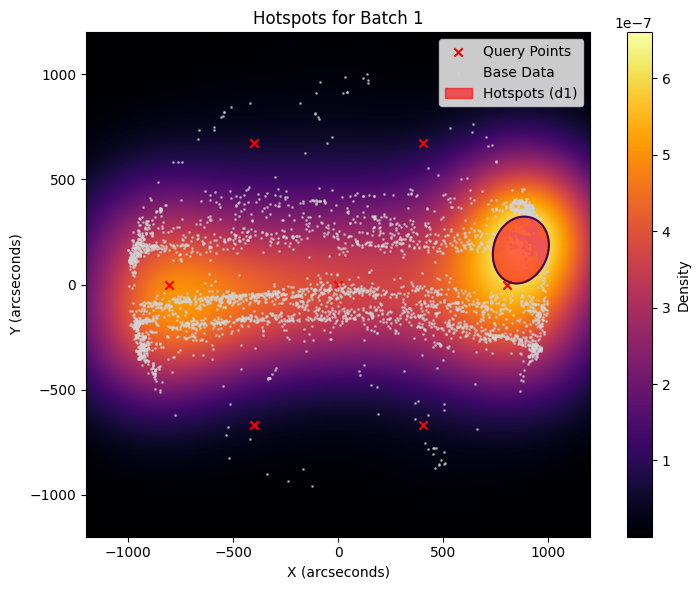

c:\Users\lythi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(
C:\Users\lythi\AppData\Local\Temp\ipykernel_11144\3117982531.py:68: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for collection in scaled_contours.collections:


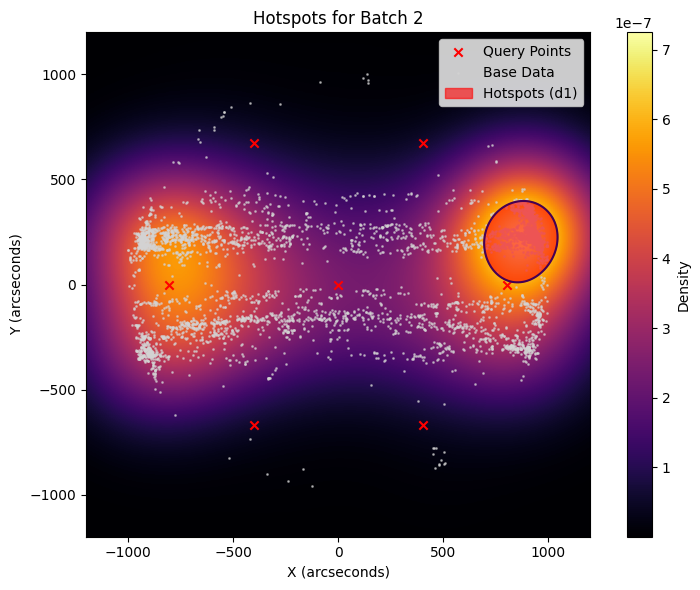

c:\Users\lythi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(
C:\Users\lythi\AppData\Local\Temp\ipykernel_11144\3117982531.py:68: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for collection in scaled_contours.collections:


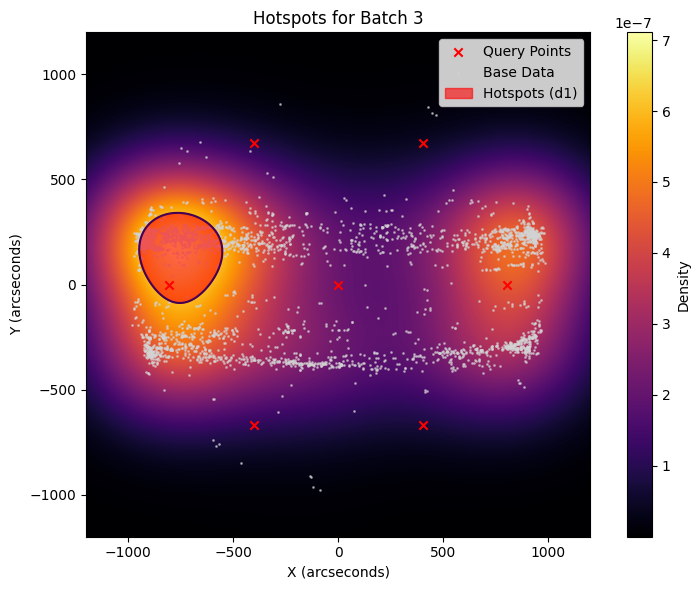

c:\Users\lythi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(
C:\Users\lythi\AppData\Local\Temp\ipykernel_11144\3117982531.py:68: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for collection in scaled_contours.collections:


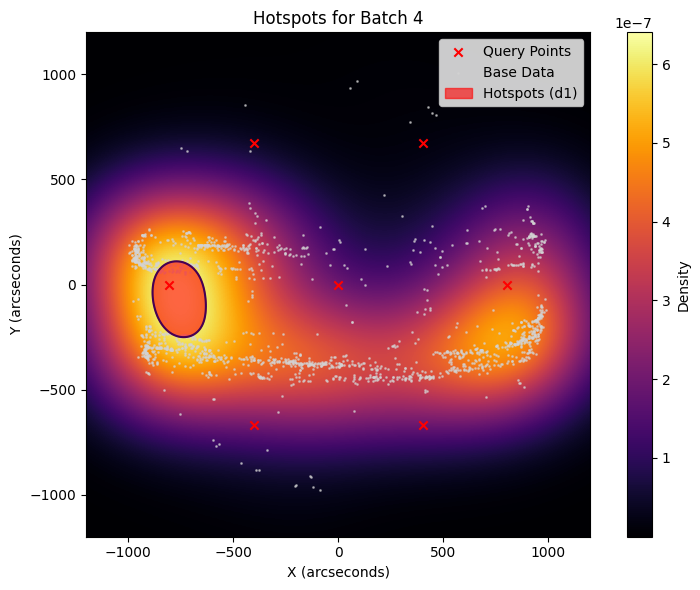

c:\Users\lythi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(
C:\Users\lythi\AppData\Local\Temp\ipykernel_11144\3117982531.py:68: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for collection in scaled_contours.collections:


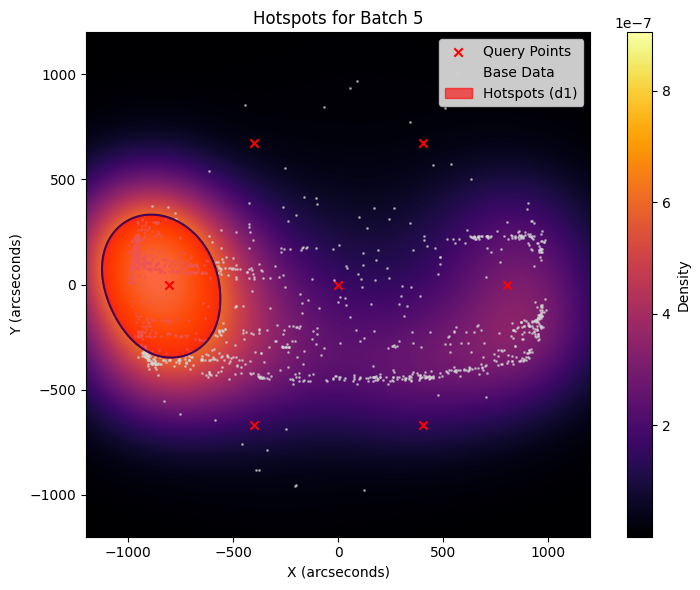

c:\Users\lythi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(
C:\Users\lythi\AppData\Local\Temp\ipykernel_11144\3117982531.py:68: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for collection in scaled_contours.collections:


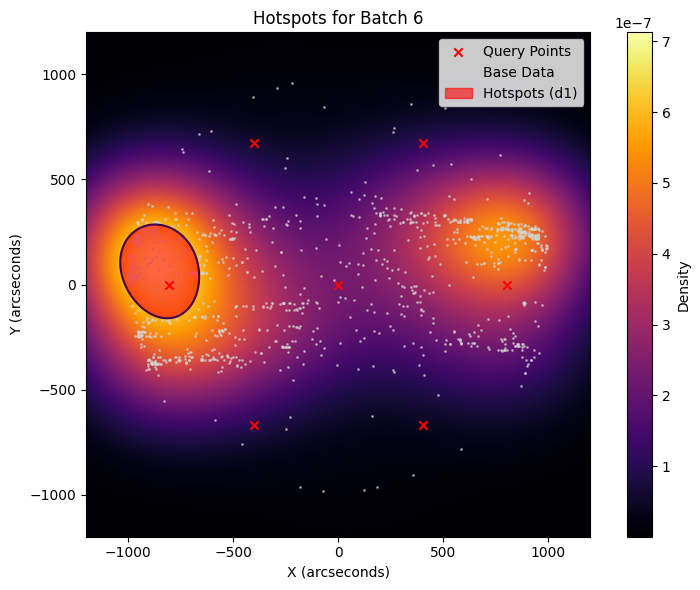

c:\Users\lythi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(
C:\Users\lythi\AppData\Local\Temp\ipykernel_11144\3117982531.py:68: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for collection in scaled_contours.collections:


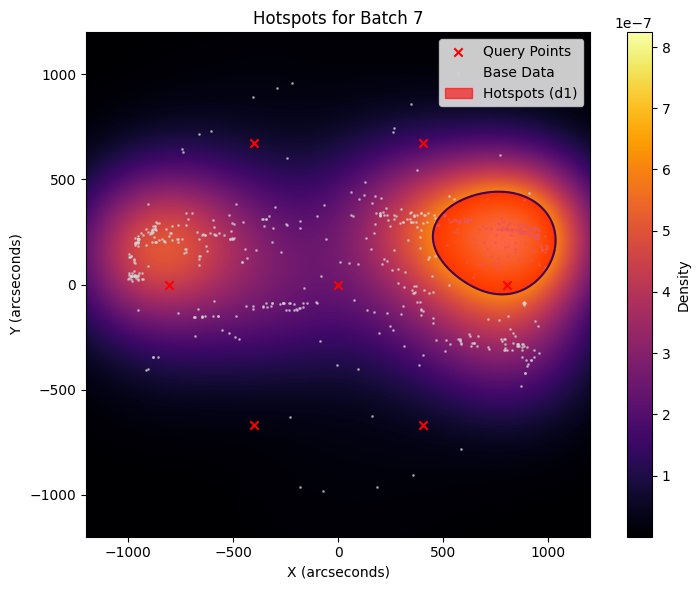

c:\Users\lythi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(
C:\Users\lythi\AppData\Local\Temp\ipykernel_11144\3117982531.py:68: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for collection in scaled_contours.collections:


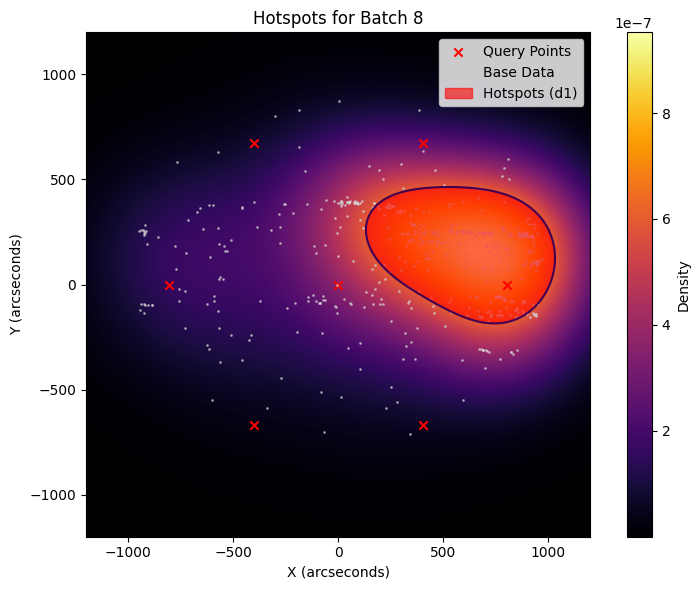

c:\Users\lythi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(
C:\Users\lythi\AppData\Local\Temp\ipykernel_11144\3117982531.py:68: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for collection in scaled_contours.collections:


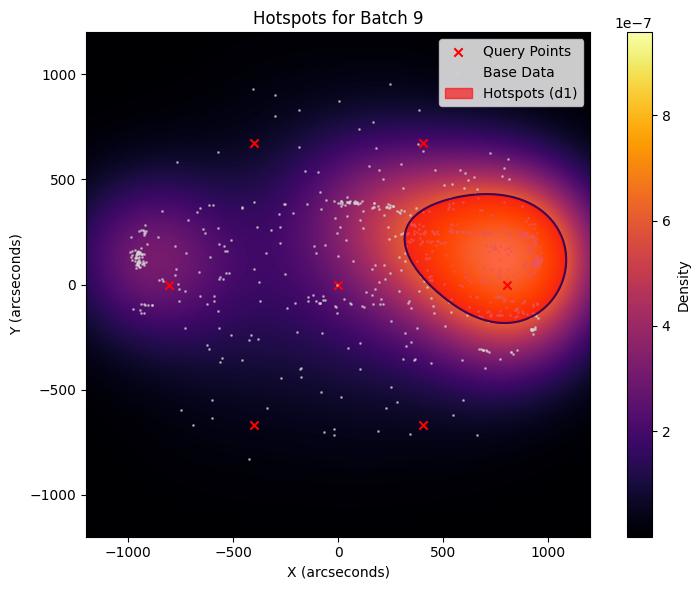

c:\Users\lythi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(
C:\Users\lythi\AppData\Local\Temp\ipykernel_11144\3117982531.py:68: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for collection in scaled_contours.collections:


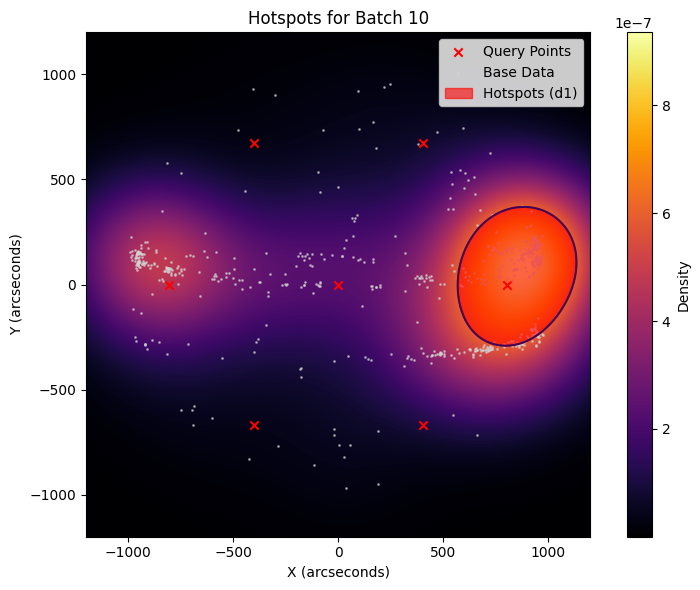

ValueError: Found array with 0 sample(s) (shape=(0, 2)) while a minimum of 1 is required by KernelDensity.

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from shapely.geometry import Polygon, MultiPolygon

dataset1 = "Solar_flare_RHESSI_2015_16.csv"
df = pd.read_csv(dataset1)


df['dt.start'] = pd.to_datetime(df['dt.start'])
start_date = pd.to_datetime('2015-01-01')
end_date = start_date + pd.DateOffset(months=24)
df = df[(df['dt.start'] >= start_date) & (df['dt.start'] <= end_date)]

flare_events = df[['total.counts', 'x.pos.asec', 'y.pos.asec']]

batch_dates = [
    (pd.to_datetime('2015-01-01'), pd.to_datetime('2015-05-01')),
    (pd.to_datetime('2015-03-01'), pd.to_datetime('2015-07-01')),
    (pd.to_datetime('2015-05-01'), pd.to_datetime('2015-09-01')),
    (pd.to_datetime('2015-07-01'), pd.to_datetime('2015-11-01')),
    (pd.to_datetime('2015-09-01'), pd.to_datetime('2016-01-01')),
    (pd.to_datetime('2015-11-01'), pd.to_datetime('2016-03-01')),
    (pd.to_datetime('2016-01-01'), pd.to_datetime('2016-05-01')),
    (pd.to_datetime('2016-03-01'), pd.to_datetime('2016-07-01')),
    (pd.to_datetime('2016-05-01'), pd.to_datetime('2016-09-01')),
    (pd.to_datetime('2016-07-01'), pd.to_datetime('2016-11-01')),
    (pd.to_datetime('2016-09-01'), pd.to_datetime('2016-01-01'))
]


query_points = {
    'Q1': {'coordinates': (0, 0), 'range': ([-201, 201], [-335, 335])},
    'Q2': {'coordinates': (-805, 0), 'range': ([-1007, -605], [-335, 335])},
    'Q3': {'coordinates': (805, 0), 'range': ([605, 1005], [-355, 335])},
    'Q4': {'coordinates': (-403, 674), 'range': ([-605, -201], [335, 1012])},
    'Q5': {'coordinates': (403, 674), 'range': ([201, 605], [335, 1012])},
    'Q6': {'coordinates': (-403, -667), 'range': ([-605, -201], [-335, -998])},
    'Q7': {'coordinates': (403, -667), 'range': ([201, 605], [-335, -998])},
}


sigma = 250.0


# create grid for density map
x_min, x_max = -1200, 1200 
y_min, y_max = -1200, 1200  
step = 10      

xx, yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


grid_points = np.vstack([xx.ravel(), yy.ravel()]).T


# create MultiPolygons
def create_multi_polygons(density_map, threshold):
    polygons = []
    contour_levels = [threshold]
    scaled_contours = plt.contour(
        np.linspace(x_min, x_max, density_map.shape[1]),
        np.linspace(y_min, y_max, density_map.shape[0]),
        density_map,
        levels=contour_levels
    )
    for collection in scaled_contours.collections:
        for path in collection.get_paths():
            for polygon in path.to_polygons():
                polygons.append(Polygon(polygon))
    return MultiPolygon(polygons)


def plot_hotspots(flare_events, multi_polygons, title):

    #base data
    plt.scatter(flare_events['x.pos.asec'], flare_events['y.pos.asec'], s=1, c='lightgray', alpha=0.6, label='Base Data')

    #MultiPolygons 
    for polygon in multi_polygons.geoms:
        x, y = polygon.exterior.xy
        plt.fill(x, y, color='red', alpha=0.6, label='Hotspots (d1)')

    plt.xlabel('X (arcseconds)')
    plt.ylabel('Y (arcseconds)')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

d1 = 6e-7
hotspot_maps = []

for batch, (batch_start, batch_end) in enumerate(batch_dates):
    current_batch_data = df[(df['dt.start'] >= batch_start) & (df['dt.start'] <= batch_end)]

    #KDE
    kde = KernelDensity(bandwidth=sigma, kernel='gaussian')
    kde.fit(current_batch_data[['x.pos.asec', 'y.pos.asec']])  

    #log-densities and density map
    log_densities = kde.score_samples(grid_points)
    density_map = np.exp(log_densities).reshape(xx.shape)

    plt.figure(figsize=(8,6))
    plt.imshow(density_map, extent=(x_min, x_max, y_min, y_max), origin='lower', cmap='inferno')
    plt.colorbar(label='Density')
    plt.scatter([p['coordinates'][0] for p in query_points.values()], [p['coordinates'][1] for p in query_points.values()], color='red', marker='x', label='Query Points')
    
    multi_polygons_d1 = create_multi_polygons(density_map, d1)
    plot_hotspots(current_batch_data, multi_polygons_d1, f'Hotspots for Batch {batch + 1}')

    hotspot_maps.append(multi_polygons_d1)

plt.show()

d2 time series for DS2

c:\Users\lythi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(
C:\Users\lythi\AppData\Local\Temp\ipykernel_11144\1734577226.py:68: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for collection in scaled_contours.collections:


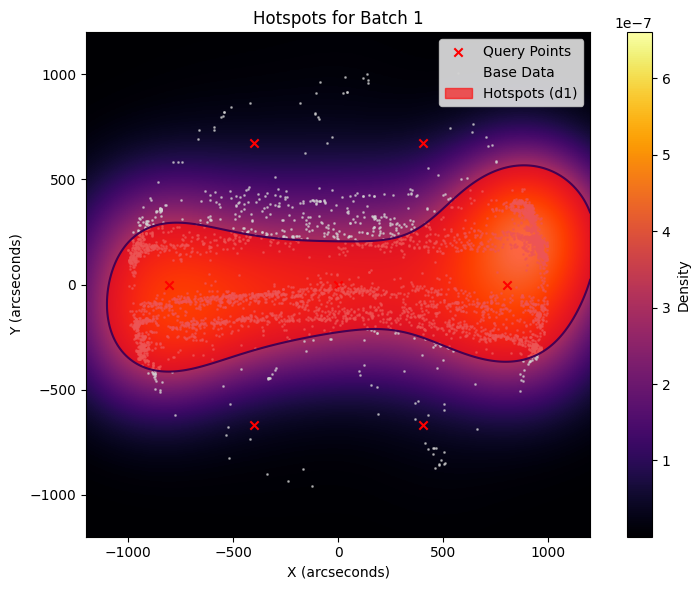

c:\Users\lythi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(
C:\Users\lythi\AppData\Local\Temp\ipykernel_11144\1734577226.py:68: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for collection in scaled_contours.collections:


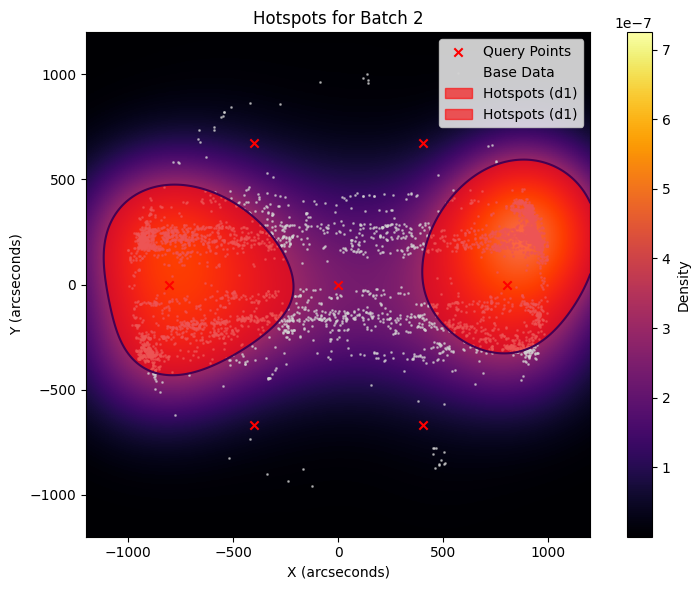

c:\Users\lythi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(
C:\Users\lythi\AppData\Local\Temp\ipykernel_11144\1734577226.py:68: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for collection in scaled_contours.collections:


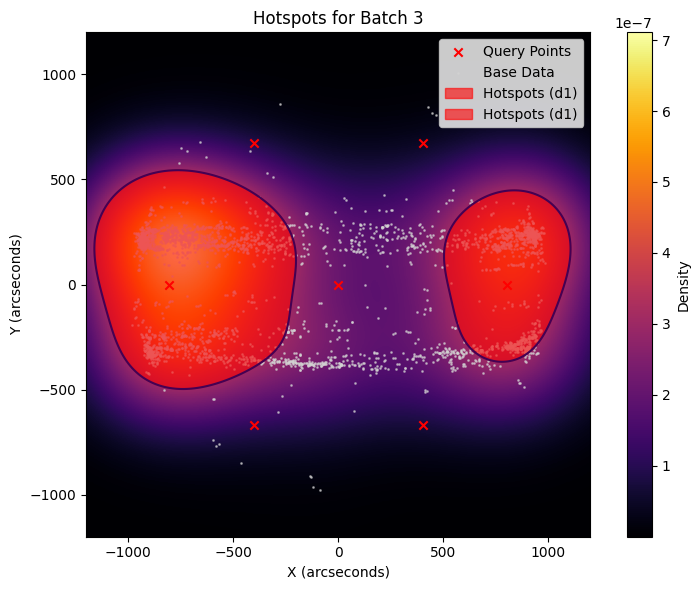

c:\Users\lythi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(
C:\Users\lythi\AppData\Local\Temp\ipykernel_11144\1734577226.py:68: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for collection in scaled_contours.collections:


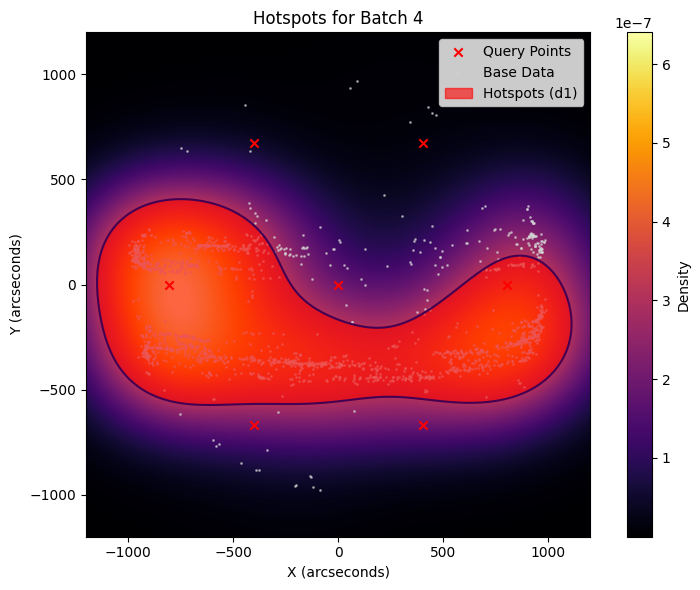

c:\Users\lythi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(
C:\Users\lythi\AppData\Local\Temp\ipykernel_11144\1734577226.py:68: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for collection in scaled_contours.collections:


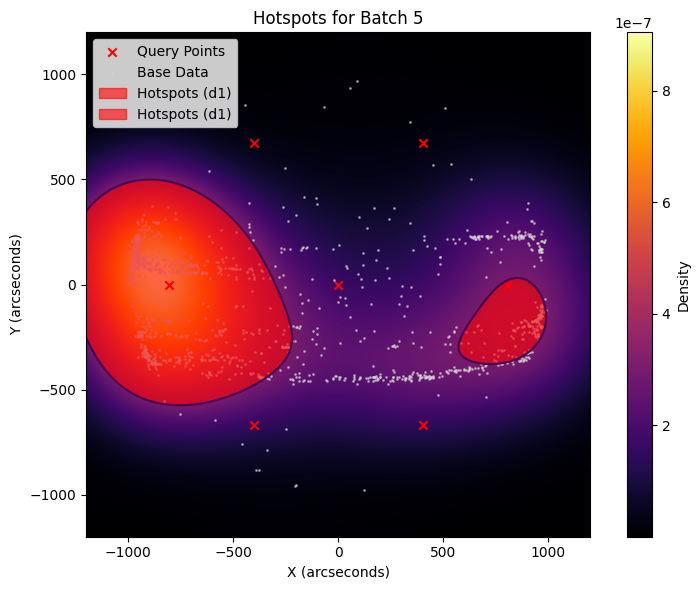

c:\Users\lythi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(
C:\Users\lythi\AppData\Local\Temp\ipykernel_11144\1734577226.py:68: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for collection in scaled_contours.collections:


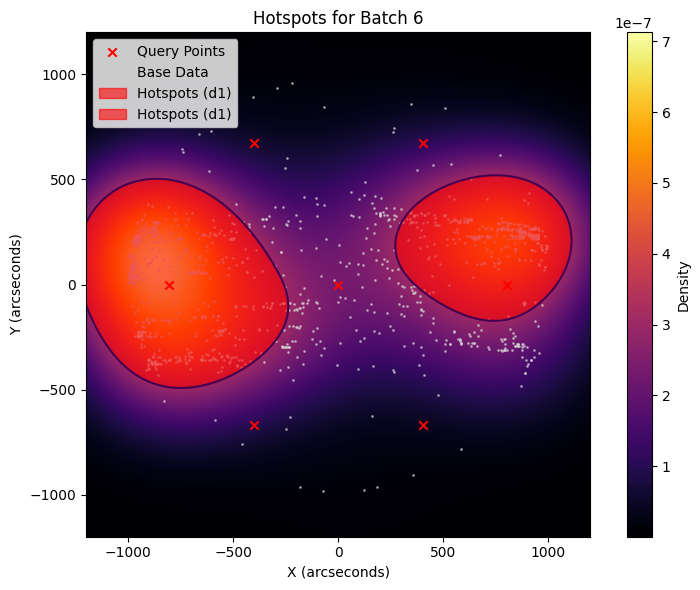

c:\Users\lythi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(
C:\Users\lythi\AppData\Local\Temp\ipykernel_11144\1734577226.py:68: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for collection in scaled_contours.collections:


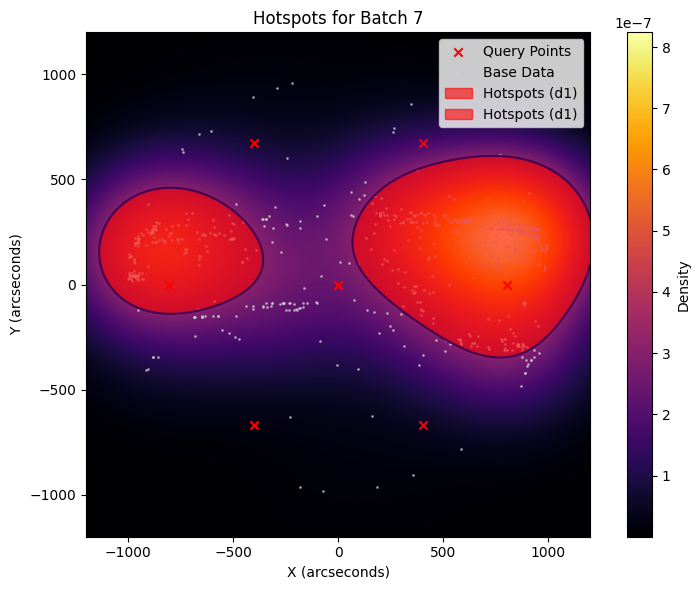

c:\Users\lythi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(
C:\Users\lythi\AppData\Local\Temp\ipykernel_11144\1734577226.py:68: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for collection in scaled_contours.collections:


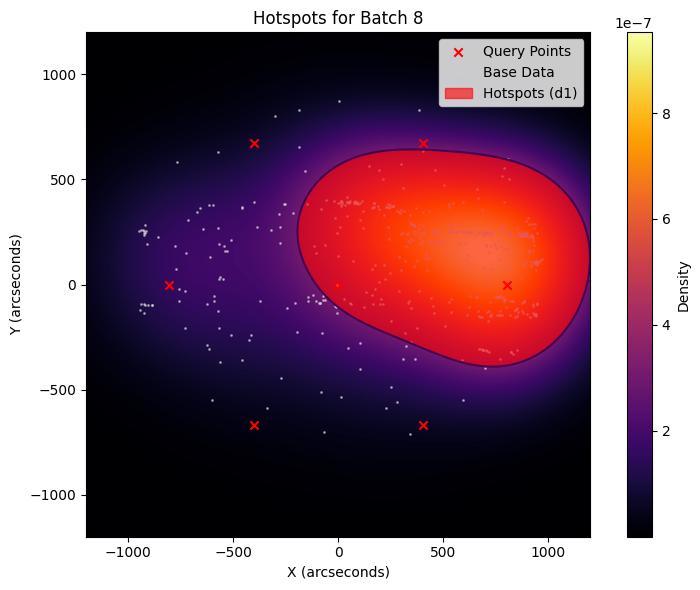

c:\Users\lythi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(
C:\Users\lythi\AppData\Local\Temp\ipykernel_11144\1734577226.py:68: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for collection in scaled_contours.collections:


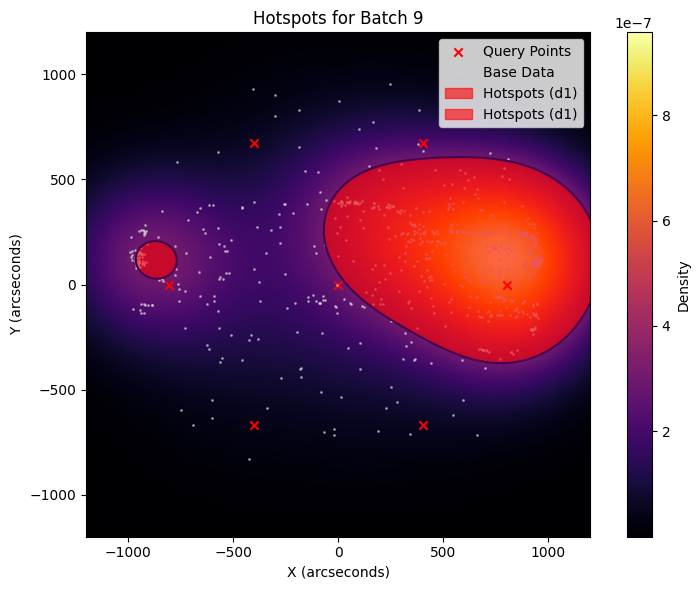

c:\Users\lythi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(
C:\Users\lythi\AppData\Local\Temp\ipykernel_11144\1734577226.py:68: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for collection in scaled_contours.collections:


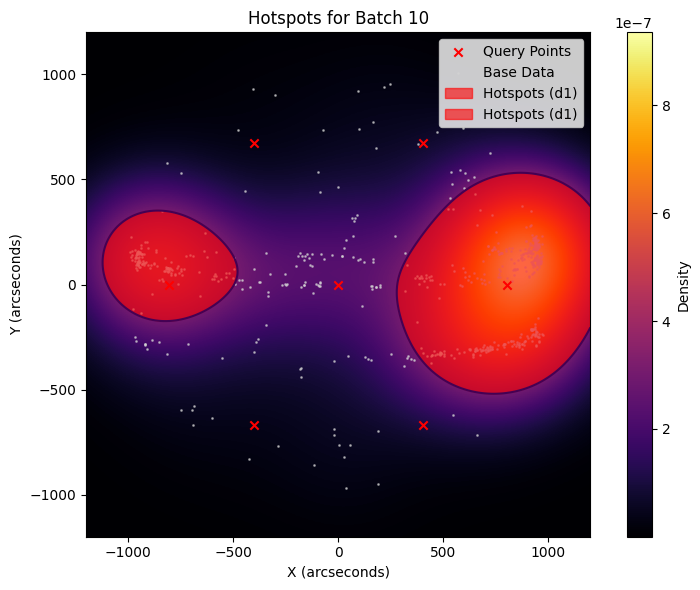

ValueError: Found array with 0 sample(s) (shape=(0, 2)) while a minimum of 1 is required by KernelDensity.

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from shapely.geometry import Polygon, MultiPolygon

dataset1 = "Solar_flare_RHESSI_2015_16.csv"
df = pd.read_csv(dataset1)


df['dt.start'] = pd.to_datetime(df['dt.start'])
start_date = pd.to_datetime('2015-01-01')
end_date = start_date + pd.DateOffset(months=24)
df = df[(df['dt.start'] >= start_date) & (df['dt.start'] <= end_date)]

flare_events = df[['total.counts', 'x.pos.asec', 'y.pos.asec']]

batch_dates = [
    (pd.to_datetime('2015-01-01'), pd.to_datetime('2015-05-01')),
    (pd.to_datetime('2015-03-01'), pd.to_datetime('2015-07-01')),
    (pd.to_datetime('2015-05-01'), pd.to_datetime('2015-09-01')),
    (pd.to_datetime('2015-07-01'), pd.to_datetime('2015-11-01')),
    (pd.to_datetime('2015-09-01'), pd.to_datetime('2016-01-01')),
    (pd.to_datetime('2015-11-01'), pd.to_datetime('2016-03-01')),
    (pd.to_datetime('2016-01-01'), pd.to_datetime('2016-05-01')),
    (pd.to_datetime('2016-03-01'), pd.to_datetime('2016-07-01')),
    (pd.to_datetime('2016-05-01'), pd.to_datetime('2016-09-01')),
    (pd.to_datetime('2016-07-01'), pd.to_datetime('2016-11-01')),
    (pd.to_datetime('2016-09-01'), pd.to_datetime('2016-01-01'))
]


query_points = {
    'Q1': {'coordinates': (0, 0), 'range': ([-201, 201], [-335, 335])},
    'Q2': {'coordinates': (-805, 0), 'range': ([-1007, -605], [-335, 335])},
    'Q3': {'coordinates': (805, 0), 'range': ([605, 1005], [-355, 335])},
    'Q4': {'coordinates': (-403, 674), 'range': ([-605, -201], [335, 1012])},
    'Q5': {'coordinates': (403, 674), 'range': ([201, 605], [335, 1012])},
    'Q6': {'coordinates': (-403, -667), 'range': ([-605, -201], [-335, -998])},
    'Q7': {'coordinates': (403, -667), 'range': ([201, 605], [-335, -998])},
}


sigma = 250.0


# create grid for density map
x_min, x_max = -1200, 1200 
y_min, y_max = -1200, 1200  
step = 10      

xx, yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


grid_points = np.vstack([xx.ravel(), yy.ravel()]).T


# create MultiPolygons
def create_multi_polygons(density_map, threshold):
    polygons = []
    contour_levels = [threshold]
    scaled_contours = plt.contour(
        np.linspace(x_min, x_max, density_map.shape[1]),
        np.linspace(y_min, y_max, density_map.shape[0]),
        density_map,
        levels=contour_levels
    )
    for collection in scaled_contours.collections:
        for path in collection.get_paths():
            for polygon in path.to_polygons():
                polygons.append(Polygon(polygon))
    return MultiPolygon(polygons)


def plot_hotspots(flare_events, multi_polygons, title):

    #base data
    plt.scatter(flare_events['x.pos.asec'], flare_events['y.pos.asec'], s=1, c='lightgray', alpha=0.6, label='Base Data')

    #MultiPolygons 
    for polygon in multi_polygons.geoms:
        x, y = polygon.exterior.xy
        plt.fill(x, y, color='red', alpha=0.6, label='Hotspots (d1)')

    plt.xlabel('X (arcseconds)')
    plt.ylabel('Y (arcseconds)')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

d2 = 3e-7
hotspot_maps = []

for batch, (batch_start, batch_end) in enumerate(batch_dates):
    current_batch_data = df[(df['dt.start'] >= batch_start) & (df['dt.start'] <= batch_end)]

    #KDE
    kde = KernelDensity(bandwidth=sigma, kernel='gaussian')
    kde.fit(current_batch_data[['x.pos.asec', 'y.pos.asec']])  

    #log-densities and density map
    log_densities = kde.score_samples(grid_points)
    density_map = np.exp(log_densities).reshape(xx.shape)

    plt.figure(figsize=(8,6))
    plt.imshow(density_map, extent=(x_min, x_max, y_min, y_max), origin='lower', cmap='inferno')
    plt.colorbar(label='Density')
    plt.scatter([p['coordinates'][0] for p in query_points.values()], [p['coordinates'][1] for p in query_points.values()], color='red', marker='x', label='Query Points')
    
    multi_polygons_d2 = create_multi_polygons(density_map, d2)
    plot_hotspots(current_batch_data, multi_polygons_d2, f'Hotspots for Batch {batch + 1}')

    hotspot_maps.append(multi_polygons_d2)

plt.show()